In [36]:
#%reset
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics
import geopandas as gpd
import geoplot as gplt
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import accuracy_score, confusion_matrix, matthews_corrcoef
from num2words import num2words
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, KFold, RepeatedStratifiedKFold
from sklearn.metrics import f1_score, matthews_corrcoef, roc_auc_score
import word2number
from word2number import w2n
from sklearn.tree import DecisionTreeClassifier
import pickle
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
import random
from matplotlib.patches import Polygon
import shap
import mapclassify as mc

from Functions import prep_training_test_data_period, prep_training_test_data, calculate_metrics,cross_validation_leave_geo_out, prep_training_test_data_shifted, add_labels_to_subplots, LOOCV_by_HSA_dataset, save_in_HSA_dictionary, prepare_data_and_model,LOOCV_by_HSA_dataset, convert_state_to_code
hfont = {'fontname':'Helvetica'}
palette = ['#66c2a5', '#fc8d62', '#8da0cb', '#e78ac3', '#a6d854', '#e5c494']
import json 

# Load data

In [37]:
HSA_weekly_data_all = pd.read_csv("/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_weekly_incl_NA.csv")


# Parameters and values 

In [38]:
no_iterations = 100
geography_column = 'HSA_ID'  
geo_split = 0.9  
time_period = 'exact'  # Choose 'period', 'exact', or 'shifted'
size_of_test_dataset = 1
train_weeks_for_initial_model = 1

weeks_in_future = 3 
weight_col = 'weight'  
keep_output = True  

no_iterations_param = 20  # Replace with the number of iterations for RandomizedSearchCV
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': np.arange(2, 5, 1)} 
# Create the Decision Tree classifier
cv = RepeatedStratifiedKFold(n_splits=10,  n_repeats=10,random_state=1) ## 10-fold cross validations

In [39]:
new_directory = '/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters'
os.chdir(new_directory)

# Testing on each HSA - full model 

In [87]:

def calculate_roc_by_hsa(hsa_weekly_data_all, directory_path, weeks_to_predict, prep_training_test_data, time_period, train_weeks_for_initial_model, size_of_test_dataset, keep_output, weeks_in_future, weight_col, geography):
    roc_by_week_full = {}
    accuracy_by_hsa_full = {}
    norm_mcc_by_hsa_full = {}

    for hsa in hsa_weekly_data_all[geography].unique():
        print(hsa)
        prediction_for_hsa_proba = []
        outcome_for_hsa = []
        for prediction_week in weeks_to_predict:
            training_dataframe, testing_dataframe = LOOCV_by_HSA_dataset(hsa_weekly_data_all, hsa, 'HSA_ID')
            if not testing_dataframe['weight'].isna().any():
                model_name_to_load = directory_path + time_period + "_" + str(prediction_week) + ".sav"
                clf = pickle.load(open(model_name_to_load, 'rb'))

                x_test_full, y_test_full, weights_test_full, missing_data_test_hsa = prep_training_test_data(testing_dataframe, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=weeks_in_future, geography=geography, weight_col=weight_col, keep_output=keep_output)
                if len(x_test_full) >= 1:
                    outcome_for_hsa.append(y_test_full.at[0,0])

                    y_pred = clf.predict(x_test_full)
                    y_pred_proba = clf.predict_proba(x_test_full)
                    prediction_for_hsa_proba.append(y_pred_proba[:, 1])

        if (sum(outcome_for_hsa) == len(outcome_for_hsa)) or (sum(outcome_for_hsa) == 0):
            roc_by_week_full[hsa] = np.nan 
        else:
            roc_by_week_full[hsa] = roc_auc_score(outcome_for_hsa, prediction_for_hsa_proba)
    
    return roc_by_week_full

In [119]:
directory_path = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/Expanding_models_15_per_100k/Full_model_exact/Full_model_smaller_hyperparameters"
weeks_to_predict = range(1, 117)
geography = 'HSA_ID'
ROC_by_week_full = calculate_roc_by_hsa(HSA_weekly_data_all, directory_path, weeks_to_predict, prep_training_test_data, time_period, train_weeks_for_initial_model, size_of_test_dataset, keep_output, weeks_in_future, weight_col, geography)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
112
114
115
116
117
119
121
122
123
124
125
126
127
128
129
130
131
132
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
256
257
258
259
260
261
262
263
264
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286

In [42]:

excluded_columns = [col for col in HSA_weekly_data_all.columns if 'death' not in col]
HSA_weekly_data_removed = HSA_weekly_data_all[ excluded_columns]

excluded_columns = [col for col in HSA_weekly_data_removed.columns if 'cases' not in col]
HSA_weekly_data_removed = HSA_weekly_data_removed[ excluded_columns]
HSA_weekly_data_removed.to_csv('/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/Expanding_models_15_per_100k/Full_model_no_cases_no_deaths/hsa_time_data_weekly_no_cases_deaths_incl_NA.csv')


In [120]:
directory_path = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/Expanding_models_15_per_100k/Full_model_no_cases_no_deaths/Full_model_smaller_hyperparameters"
#HSA_weekly_data_removed = pd.read_csv('/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/Expanding_models_15_per_100k/Full_model_no_cases_no_deaths/hsa_time_data_weekly_no_cases_deaths_incl_NA.csv')
weeks_to_predict = range(1, 117)
geography = 'HSA_ID'
ROC_by_week_no_case_death = calculate_roc_by_hsa(HSA_weekly_data_removed, directory_path, weeks_to_predict, prep_training_test_data, time_period, train_weeks_for_initial_model, size_of_test_dataset, keep_output, weeks_in_future, weight_col, geography)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
112
114
115
116
117
119
121
122
123
124
125
126
127
128
129
130
131
132
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
256
257
258
259
260
261
262
263
264
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286

# Try a map 

In [121]:
data_by_HSA = pd.read_csv('/Users/rem76/Documents/COVID_projections/hsa_time_data_all_dates_with_state_fips.csv')
data_by_HSA.rename(columns={'health_service_area_number': 'HSA_ID'}, inplace=True)

Columns (43,45,46,48,52,53) have mixed types. Specify dtype option on import or set low_memory=False.


In [122]:
# Load the json file with county coordinates
geoData = gpd.read_file('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/US-counties.geojson')

# Make sure the "id" column is an integer
geoData.id = geoData.id.astype(str).astype(int)

# Try and match to states 
census_data = pd.read_csv('https://raw.githubusercontent.com/holtzy/The-Python-Graph-Gallery/master/static/data/unemployment-x.csv')

geoData = geoData.merge(census_data, left_on=['id'], right_on=['id'])

In [46]:
def convert_state_to_code(dataframe, column_name):
    # List of state names in alphabetical order, including Washington, D.C.
    state_names = [
        'Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
        'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho',
        'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana',
        'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota',
        'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
        'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota',
        'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina',
        'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington',
        'West Virginia', 'Wisconsin', 'Wyoming', 'Washington D.C.'
    ]

    # Create a dictionary to map state names to numerical codes
    state_to_code = {state: f'{index + 1:02}' for index, state in enumerate(state_names)}

    # Create a new column "state_code" based on the mapping
    dataframe['state_code'] = dataframe[column_name].map(state_to_code)
    
    return dataframe

In [123]:
data_by_HSA = convert_state_to_code(data_by_HSA, 'state')

In [124]:
geoData['HSA_ID'] = None
for i, name in enumerate(geoData['id']):
    state = geoData.loc[i, 'state']
    filtered_rows = data_by_HSA[data_by_HSA['fips'] == name ]

    if(len(filtered_rows) > 1): #ensures that only HSAs that are represented in the geoData are used
        geoData.loc[i, 'HSA_ID'] = filtered_rows['HSA_ID'].reset_index(drop=True)[0]


for i, HSA in enumerate(data_by_HSA['HSA_ID']):
    geoData.loc[geoData['HSA_ID'] == HSA, 'auROC'] = ROC_by_week_full[HSA]


In [125]:
for i, HSA in enumerate(data_by_HSA['HSA_ID']):
    geoData.loc[geoData['HSA_ID'] == HSA, 'auROC_no_cases_deaths'] = ROC_by_week_no_case_death[HSA]

In [126]:



# Remove Alaska, HI, Puerto Rico (to be plotted later)
stateToRemove = ['02', '15', '72']
geoData_mainland = geoData[~geoData.STATE.isin(stateToRemove)]

# Explode the MultiPolygon geometries into individual polygons
geoData_mainland = geoData_mainland.explode()



Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.


The data being passed to "hue" includes null values. You probably want to remove these before plotting this data with geoplot.


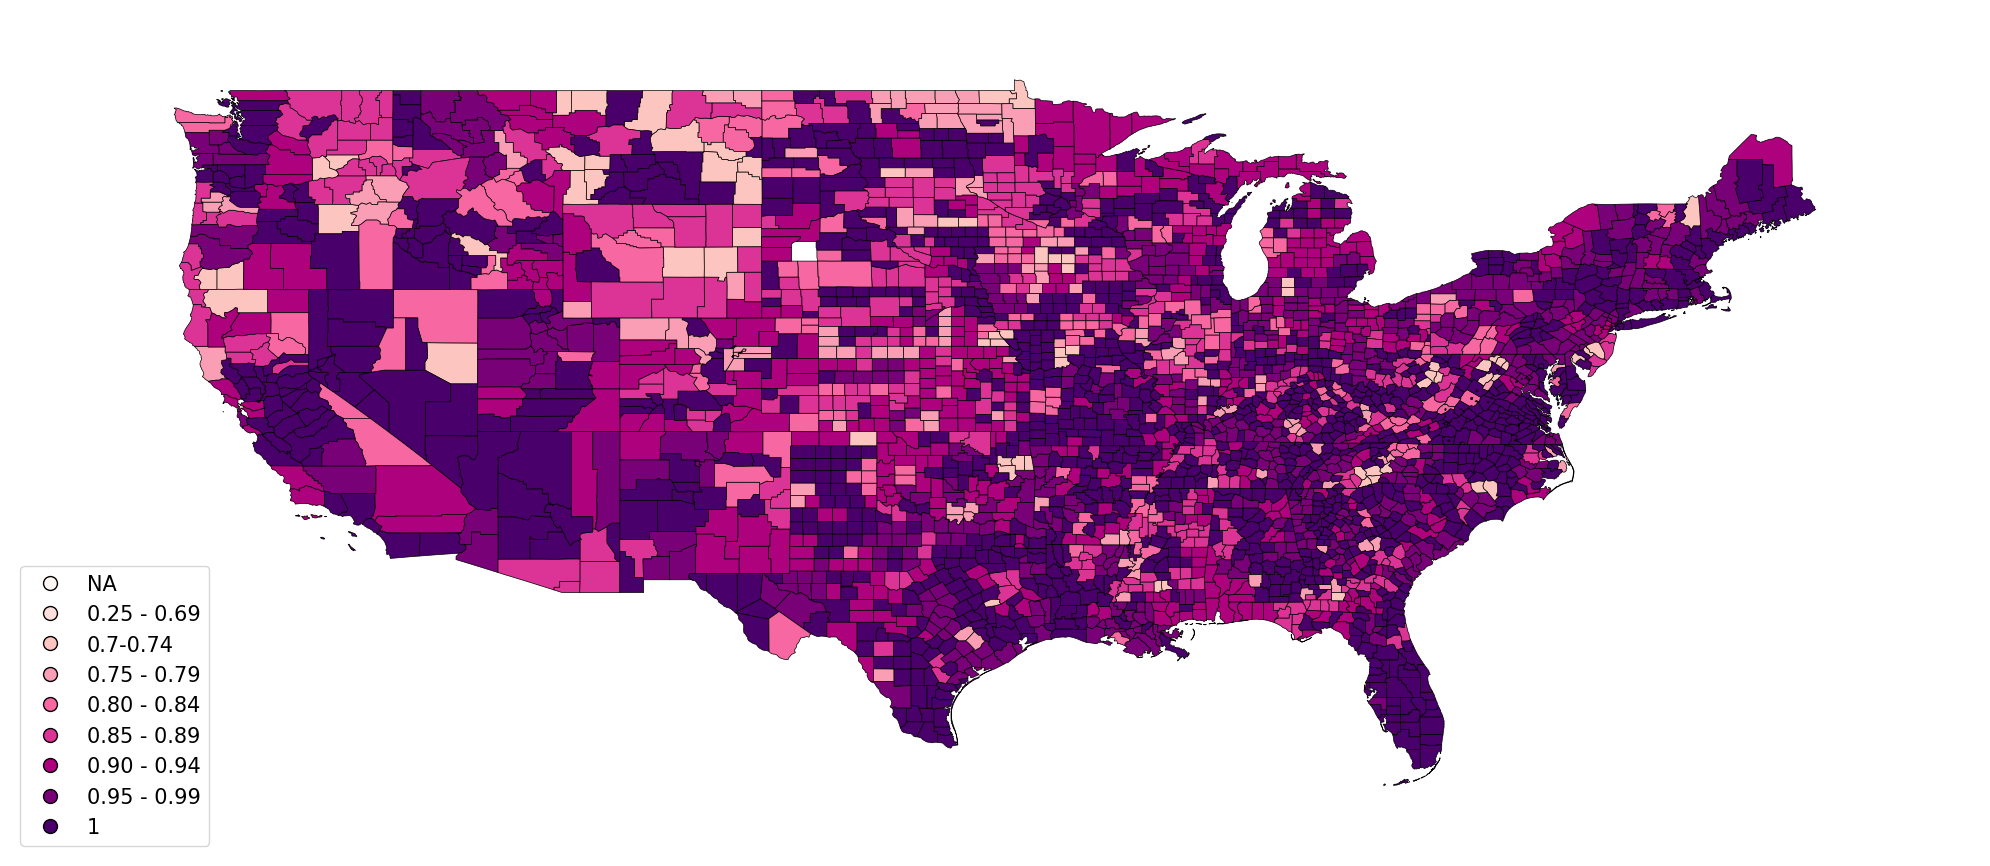

In [168]:
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

geoData_filtered = geoData_mainland.copy()
#geoData_filtered['auROC'].replace(np.nan, -1, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
custom_quantiles = [0,0.25, 0.7,0.75, 0.8, 0.85,  0.9, 0.95,1.0]

#custom_quantiles = [0, 0.01,0.03, 0.04, 0.05,0.25, 0.7,0.75, 0.8, 0.85,  0.9, 0.95,1.0]

scheme = mc.UserDefined(geoData_filtered['auROC'], custom_quantiles)
geoData_filtered['facecolor'] = 'lightgray'
cmap = ['#f0f0f0', '#e5f5f9', '#ccece6', '#99d8c9', '#66c2a4', '#41ae76', '#238b45', '#005824', '#00441b']


gplt.choropleth(geoData_filtered, 
    hue="auROC", 
    linewidth=.5,
    scheme=scheme, 
    cmap='RdPu',
    legend=True,
    edgecolor='black', 
    ax=ax,
    legend_labels=[
        'NA', '0.25 - 0.69', '0.7-0.74',
        '0.75 - 0.79', '0.80 - 0.84', '0.85 - 0.89', '0.90 - 0.94', '0.95 - 0.99', '1'
    ],
    legend_kwargs={'prop': {'size': 15}}
);

plt.tight_layout()
#plt.savefig('/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Plot_by_county_full_classifier.png', dpi = 300)

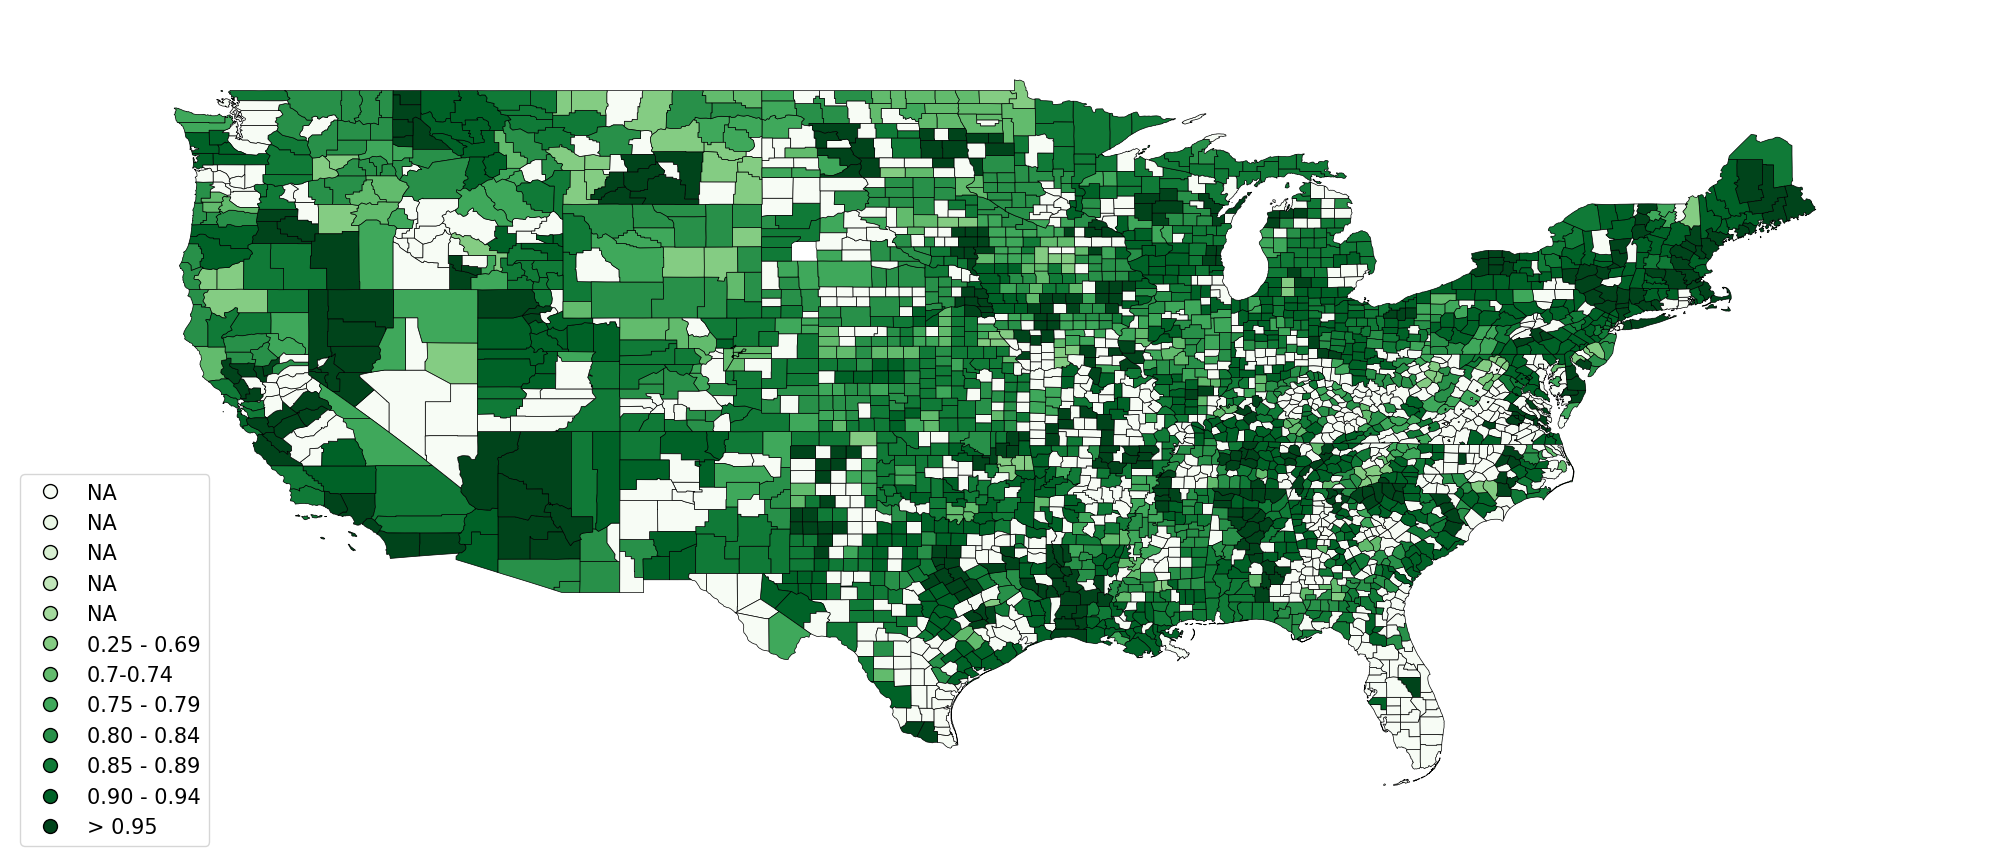

In [176]:
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

geoData_filtered = geoData_mainland.copy()
geoData_filtered['auROC'].replace(np.nan, -1, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
custom_quantiles = [0,0.25, 0.7,0.75, 0.8, 0.85,  0.9, 0.95,1.0]

custom_quantiles = [0, 0.01,0.04, 0.05,0.25, 0.7,0.75, 0.8, 0.85,  0.9, 0.95,1.0]

scheme = mc.UserDefined(geoData_filtered['auROC'], custom_quantiles)
geoData_filtered['facecolor'] = 'lightgray'


gplt.choropleth(geoData_filtered, 
    hue="auROC", 
    linewidth=.5,
    scheme=scheme, 
    cmap='Greens',
    legend=True,
    edgecolor='black', 
    ax=ax,
    legend_labels=[
        'NA', 'NA', 'NA', 'NA', 'NA', '0.25 - 0.69', '0.7-0.74',
        '0.75 - 0.79', '0.80 - 0.84', '0.85 - 0.89', '0.90 - 0.94', '> 0.95'
    ],
    legend_kwargs={'prop': {'size': 15}}
);

plt.tight_layout()
plt.savefig('/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Plot_by_county_full_classifier.png', dpi = 300)

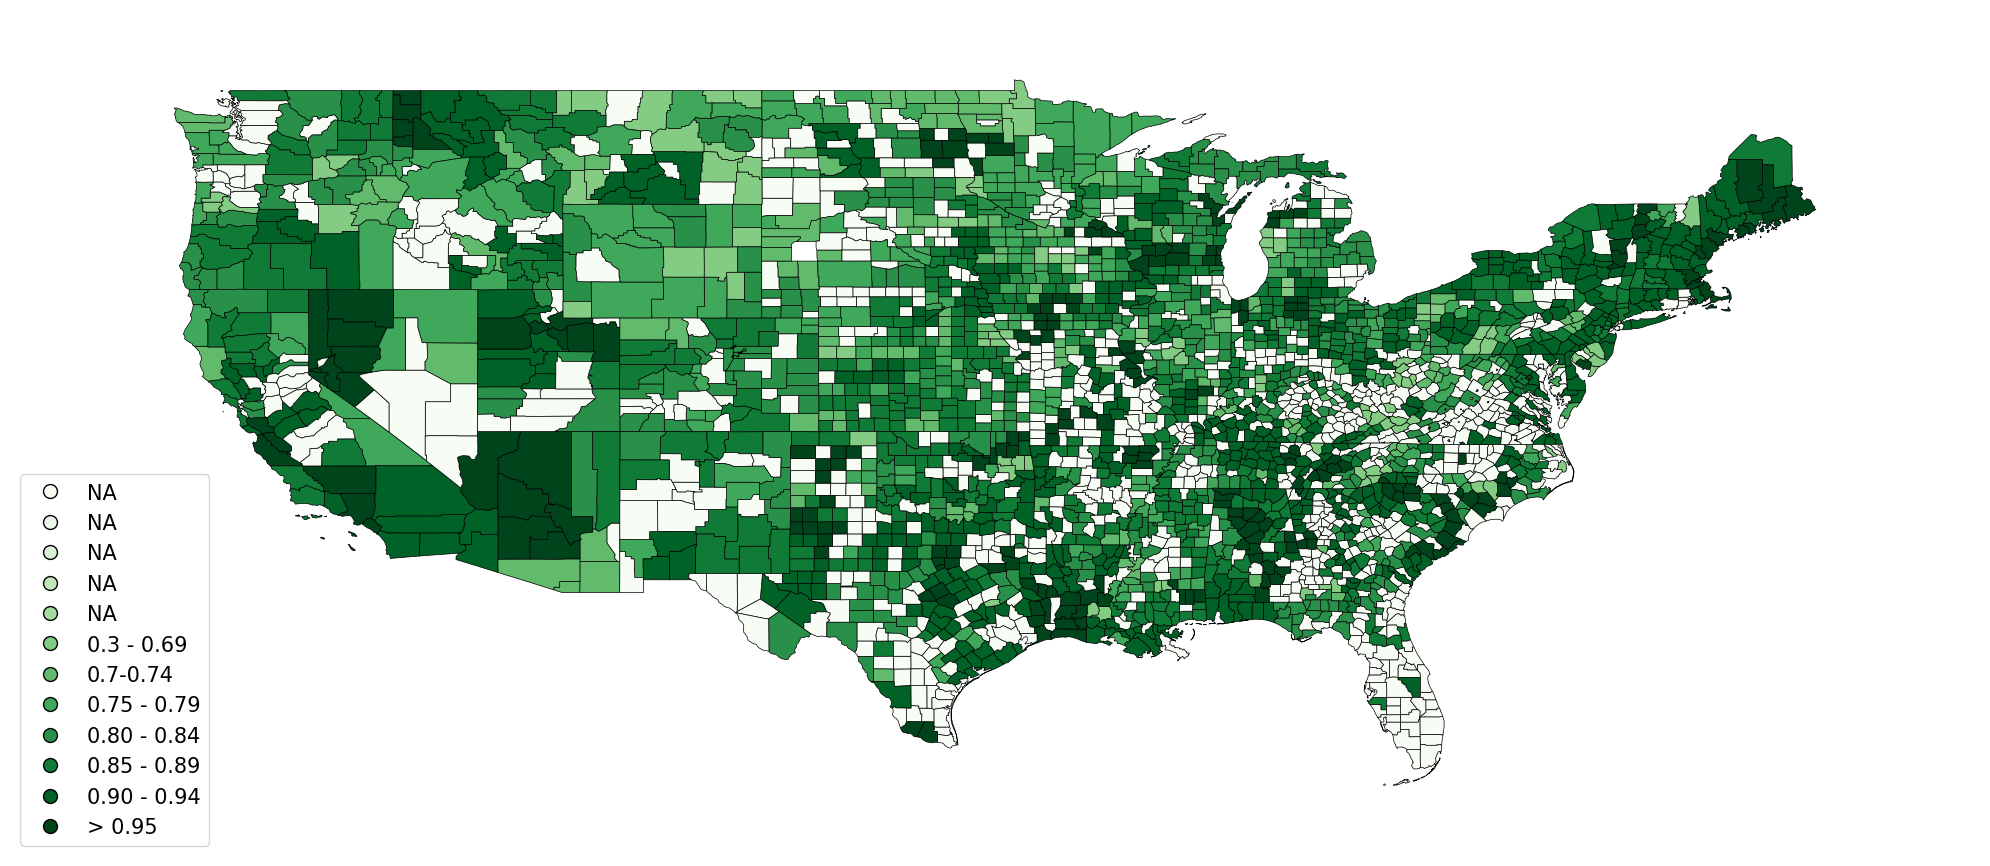

In [177]:
geoData_filtered = geoData_mainland.copy()
geoData_filtered['auROC_no_cases_deaths'].replace(np.nan, 0, inplace=True)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
custom_quantiles = [0, 0.7,0.75, 0.8, 0.85,  0.9, 0.95,1.0]
custom_quantiles = [0, 0.01,0.04, 0.05,0.3, 0.7,0.75, 0.8, 0.85,  0.9, 0.95,1.0]

scheme = mc.UserDefined(geoData_filtered['auROC_no_cases_deaths'], custom_quantiles)

gplt.choropleth(geoData_filtered, 
    hue="auROC_no_cases_deaths", 
    linewidth=.5,
    scheme=scheme, 
    cmap='Greens',
    legend=True,
    edgecolor='black', 
    ax=ax,
    legend_labels=[
        'NA', 'NA', 'NA', 'NA', 'NA', '0.3 - 0.69', '0.7-0.74',
        '0.75 - 0.79', '0.80 - 0.84', '0.85 - 0.89', '0.90 - 0.94', '> 0.95'
    ],
    legend_kwargs={'prop': {'size': 15}}
);
plt.tight_layout()
plt.savefig('/Users/rem76/Documents/COVID_projections/Exact_analysis/Graphs/Plot_by_county_co_cases_no_deaths.png', dpi = 300)

# How many HSAs are always over? 

In [57]:
testing_dataframe

,HSA_ID,week_one_admits,week_one_icu,week_one_beds,week_one_perc_covid,week_one_admits_delta,week_one_icu_delta,week_one_beds_delta,week_one_perc_covid_delta,week_one_beds_over_15_100k,...,week_one hundred and twenty-two_admits,week_one hundred and twenty-two_icu,week_one hundred and twenty-two_beds,week_one hundred and twenty-two_perc_covid,week_one hundred and twenty-two_admits_delta,week_one hundred and twenty-two_icu_delta,week_one hundred and twenty-two_beds_delta,week_one hundred and twenty-two_perc_covid_delta,week_one hundred and twenty-two_beds_over_15_100k,weight
54,55,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,0.0,...,0.0,NaN,NaN,0.0,-16.433854,NaN,NaN,-0.101045,0.0,0.000047


In [59]:
HSA_always_over = 0 

weeks_to_predict = [117]

for HSA in HSA_weekly_data_all['HSA_ID'].unique():
    print(HSA)
    prediction_for_HSA_proba = []
    outcome_for_HSA = []
    for prediction_week in weeks_to_predict:
        training_dataframe, testing_dataframe = LOOCV_by_HSA_dataset(HSA_weekly_data_removed, HSA, 'HSA_ID')
        if not testing_dataframe['weight'].isna().any():
            model_name_to_load = "/Users/rem76/Documents/COVID_projections/Exact_analysis_smaller_hyperparameters/Expanding_models_15_per_100k/Full_model_no_cases_no_deaths/Full_model_smaller_hyperparameters" + time_period + "_" + str(prediction_week) + ".sav"
            clf_full_period = pickle.load(open(model_name_to_load, 'rb'))


            X_test_full, y_test_full, weights_test_full, missing_data_test_HSA = prep_training_test_data(testing_dataframe, no_weeks=range(int(prediction_week + train_weeks_for_initial_model) + 1, int(prediction_week + train_weeks_for_initial_model + size_of_test_dataset) + 1), weeks_in_future=3, geography='HSA_ID', weight_col='weight', keep_output=keep_output)
            if len(X_test_full) >= 1:
                outcome_for_HSA.append(y_test_full.at[0,0])



    if (sum(outcome_for_HSA) == len(outcome_for_HSA)):
        HSA_always_over += 1


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
112
114
115
116
117
119
121
122
123
124
125
126
127
128
129
130
131
132
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
256
257
258
259
260
261
262
263
264
266
267
268
269
270
271
272
273
274
275
276
277
278
279
280
281
282
283
284
285
286

In [65]:
HSA_always_over/len(HSA_weekly_data_all['HSA_ID'].unique())

0.22885572139303484